In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


ftr = open("polarity.train", "r",  encoding="ISO-8859-1")
rows = [line.split(" ",1) for line in ftr.readlines()]
df_train = pd.DataFrame(rows, columns=['Sentiment','Text'])
df_train['Sentiment'] = (pd.to_numeric(df_train['Sentiment'])+1)/2 # 0 o 1
fts = open("polarity.dev", "r",  encoding="ISO-8859-1")
rows1 = [line.split(" ",1) for line in fts.readlines()]
df_test = pd.DataFrame(rows1, columns = ['Sentiment', 'Text'])
df_test['Sentiment'] = (pd.to_numeric(df_test['Sentiment'])+1)/2

Ya habiendo abierto los datos y asignado los datos INPUTs con sus respectivo OUTPUTs, nuestro objetivo es ver la 'calidad' de los datos. Debido a que es un problema de clasificación, estudiamos principalmente la cantidad de categorias y la cantidad de datos en cada una de ellas.
Como se puede ver en los print de abajo, tenemos 3554 datos de entrenamiento y testeo, de los cuales existen 1770 reseñas postivias y 1751 reseñas negativas en el conjunto de entrenamiento. En general, esto es un problema cuando las categorias están drásticamente desbalanceadas (e.g, 3000 positivas y 554 negativas), ya que al momento de entrenar, nuestro modelo tenderá a entender solamente las frases que son positivas.

Pero como se mencionó anteriormente, debido a lo balanceado de las reseñas, esperamos no tener un entrenamiento sesgado hacía ningún lado.

In [10]:
#A)

df_train_text = df_train.Text
df_test_text = df_test.Text
labels_train = df_train.Sentiment.values
labels_test = df_test.Sentiment.values

print(df_train.shape, df_test.shape)
print('cantidad de reseñas positivas para entrenar= ', np.argwhere(labels_train == 1).shape[0])
print('cantidad de reseñas positivas para testear= ', np.argwhere(labels_test == 1).shape[0])
print('Oración de entrenamiento más larga: ', max([len(i) for i in df_train_text]))
#Notar que has 1784 reseñas negativas para entrenar
# y 1803 reseñas negativas para testear. Por lo tanto existe una pequeña inclinación hacia las evaluadas negativamente

(3554, 2) (3554, 2)
cantidad de reseñas positivas para entrenar=  1770
cantidad de reseñas positivas para testear=  1751
Oración de entrenamiento más larga:  267


Como se señaló anteriormente, la idea de un buen balance en las respuesta es clave al momento de entrenar un modelo insesgado, es por eso que al hacer el split de los datos de entrenamiento para obtener el de validación, stratificamos las etiquetas del conjunto para mantener la misma proporción de reseñas positivas y negativas.

In [0]:
#B)

from sklearn.model_selection import train_test_split 

df_train_text, df_val_text, labels_train, labels_val = train_test_split(df_train_text, labels_train, test_size=0.2, 
                                                                        stratify = labels_train)


#PRE-PROCESAMIENTO

In [12]:
#C)
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

import re, time
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer, word_tokenize
def base_word(word):
    wordlemmatizer = WordNetLemmatizer()
    return wordlemmatizer.lemmatize(word) 
def word_extractor(text):
    commonwords = stopwords.words('english')
    text = re.sub(r'([a-z])\1+', r'\1\1',text) #substitute multiple letter by two
    words = ""
    wordtokens = [ base_word(word.lower()) for word in word_tokenize(text) ]
    for word in wordtokens:
        if word not in commonwords: #delete stopwords
            words+=" "+word
    return words


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [13]:
print(word_extractor("I love the taste of this cakes"),
word_extractor("I HATE THE HEAT "),
word_extractor("I love Machine Learning"),
word_extractor("I do love have homework when I supposed to have rest days"),
word_extractor("I don't love eating cake"))


 love taste cake  hate heat  love machine learning  love homework supposed rest day  n't love eating cake


Sin duda alguna, acabamos de realizar la parte más importante de la tarea. Y es que realizar un buen pre procesamiento de ellos para entregarlos a nuestro modelo es crucial.

Debido a que estamos trabajando con reseñas, muchas de ellas están escritas en mayusuculas, poseen muchos artículos y conectores que pueden confundir a nuestro modelo. Entonces lo que buscamos es estudiar las palabras esenciales de las cuales podemos deducir si la reseña a estudiar es positiva o negativa.
En lo ejemplo anteriores, podemos ver que la oración 'I HATE THE HEAT' queda transformada a 'HATE HEAT', lo cual es el cuerpo indispensable de nuestra reseña y que nos hace inmediatamente identificar que la frase es negativa.
Lo anterior es lo que se busc ( y se hizo ) hacer con todas las oraciones de nuestro conjunto de entrenamiento para que nuestro modelo aprena a identificar las palabras que hacen de la oración positiva o negativa. 

In [0]:
texts_train = [word_extractor(text) for text in df_train_text]
texts_val = [word_extractor(text) for text in df_val_text]
texts_test = [word_extractor(text) for text in df_test_text]

Ya con los cuerpo de las oraciones en mano, debemos transformar los datos de tal manera que se los podamos entregar a nuestro modelo, ya que no podemos entregarle solamente strings porque...bueno, sólo son strings para nuestra máquina.

Existen distintas formas de procesar los datos de texto (como el one-hot-vector o el embbeding). Lo que hicimos, fue utilizar el vocabulario base de nuestro conjunto de entrenamiento (en principio utilizamos todas palabras, incluso las de frecuencia 1) y creamos una matriz de NxV, donde N es la cantidad de oraciones en nuestro conjunto de entrenamiento (2843) y V es la cantindad de palabras distintas en nuestro conjunto de entrenamiento (8645). Notar que esta cantidad de palabras, son aquellas palabras ya transformadas a minúsculas y con los artículos y conectores removidos. Por lo tanto, la mayoría de ellas son esenciales.

In [0]:
#D)
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(ngram_range=(1, 1), binary=False) #TF representation
vectorizer.fit(texts_train)
features_train = vectorizer.transform(texts_train)
features_val = vectorizer.transform(texts_val)
features_test= vectorizer.transform(texts_test)
#transform val and test
vocab = vectorizer.get_feature_names() #Palabras en nuestro vocabulario = 8595
dist=list(np.array(features_train.sum(axis=0)).reshape(-1,))

Podemos observar que cada entrada de nuestro conjunto de entrenamiento es un vector que mide la frecuencia de cada palabra en la oración.

In [16]:
print('Largo de nuestro vocabulario: ' ,len(vocab))
print(features_train.shape)
for k in features_train[0]:
  print(k)
for k in texts_train[0].split(' '):
  if k in vocab:
    print(k)

Largo de nuestro vocabulario:  8592
(2843, 8592)
  (0, 866)	1
  (0, 2101)	1
  (0, 2386)	1
  (0, 2471)	1
  (0, 3856)	1
  (0, 4176)	1
  (0, 4765)	1
  (0, 4798)	1
  (0, 4923)	1
  (0, 4971)	1
  (0, 5100)	1
  (0, 5256)	1
  (0, 6677)	1
  (0, 6997)	1
  (0, 7063)	1
  (0, 7112)	1
  (0, 7631)	1
  (0, 8345)	1
  (0, 8500)	1
mesh
incarnated
movie
soundtrack
joyful
effusion
disco
bollywood
end
monsoon
wedding
sent
spirit
soaring
theater


Abajo se pueden observar una tabla que muestra las 10 palabras más frecuentes, siendo liderada por la palabra 'film'. Abajo de este cuadro, es posible ver la gráfica de cómo se distribuyen estas palabras y claramente podemos apreciar que cumple la ley Zipf (que se distribuyen de forma exponencial, con coeficiente un poco menor que -1)

In [17]:
#Notar que cumple la ley zipf
data = pd.DataFrame({'Palabras': vocab, 'Frecuencia': dist})
data = data.sort_values(by='Frecuencia', ascending = False)
data_train = data.set_index(np.arange(0,data.shape[0]))

data_train.head(10)
#plt.plot(np.log(data1['Frecuencia']), 'x')

,Palabras,Frecuencia
0,film,456
1,movie,426
2,like,211
3,one,205
4,ha,192
5,make,146
6,story,139
7,character,128
8,good,123
9,comedy,120


Text(200, 440, 'film')

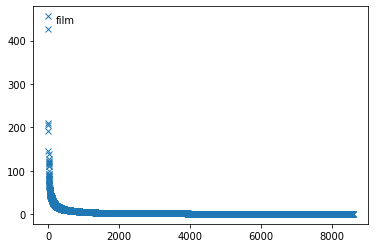

In [18]:
plt.plot(data_train['Frecuencia'], 'x')
plt.annotate('film', xy=(0,data_train['Frecuencia'].values[0] ), xytext=(200, 440),)

Luego de vectorizar las palabras, realizamos un representación D de los datos para estudiar algún tipo de comportamiento que tengan las categorias. Gracias a la imagen de abajo, es posible ver que ambas categorias se comportan de manera similar en cuanto a la semántica de las oraciones respecta y siguen los mismo patrones, por lo tanto no es posible destacar algo, a priori, de alguna de las categorias. Tal vez que el problema se comporta lineal de cierta forma, pero no se puede asegurar.

Si bien, en base a la imagen es posible colegir que la frontera entre ellos es no-lineal, no es posible asegurar lo anterior debido a que los vector son de dimensión 8645 (cantidad de palabras) por lo tanto, la noción que estamos viendo ahora se pierde en dimensiones tan grandes. 

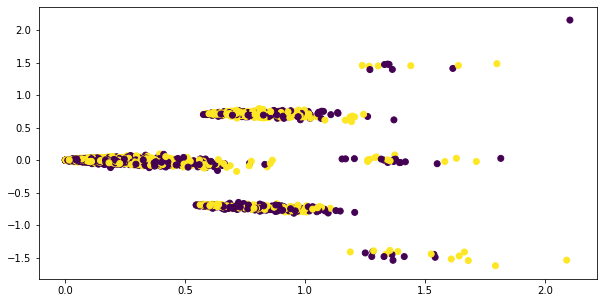

In [19]:
data1 = pd.DataFrame({'Palabras': vocab, 'Frecuencia_test':list(np.array(features_test.sum(axis=0)).reshape(-1,))})
data1= data1.sort_values(by='Frecuencia_test', ascending = False)
data_test = data1.set_index(np.arange(0,data1.shape[0]))

#E)

from sklearn.decomposition import TruncatedSVD
model = TruncatedSVD(n_components=2)
model.fit(features_train)
x_plot = model.transform(features_train)
plt.figure(figsize=(10,5))
plt.scatter(x_plot[:,0], x_plot[:,1], c=labels_train)
plt.show()

A continuación se entrenarán 5 modelos distintos de nuestro espacio de hipótesis, a saber, un modelo de regresión logística, una SVM, un k-NN, un árbol de decisión y una red neuronal. En cada uno de ellos, se iterará un parámetro específico de cada modelo, y se graficarán los errores. Se compararán los modelos y al final de esto, discutiremos cuál fue mejor.

Param C=  0.0001
Param C=  0.001
Param C=  0.01
Param C=  0.1
Param C=  1.0
Param C=  10.0
Param C=  100.0
Param C=  1000.0
Accuracy Máxima es  0.7158931082981715  y se alcanza en el parámetro C=  1.0


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


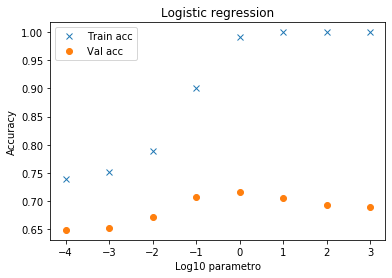

In [20]:
#Regresión Logística

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge

from sklearn.linear_model import LogisticRegression
def do_LOGIT(x,y,xv,yv, param):
    print("Param C= ",param)
    model= LogisticRegression()
    model.set_params(C=param)
    model.fit(x,y)
    train_acc = model.score(x,y)
    test_acc = model.score(xv,yv)
    return model, train_acc, test_acc
Cs = [10**i for i in np.arange(-4,4, dtype = 'float')]

train_log_acc = []
val_log_acc = []
for k in Cs:
  a,b,c = do_LOGIT(features_train, labels_train, features_val, labels_val, k)
  train_log_acc = train_log_acc + [b]
  val_log_acc = val_log_acc + [c]

plt.plot(np.log10(Cs), train_log_acc, 'x', label = 'Train acc')
plt.plot(np.log10(Cs), val_log_acc, 'o', label= 'Val acc')
plt.xlabel('Log10 parametro')
plt.ylabel('Accuracy')
plt.title('Logistic regression')
plt.legend()

print('Accuracy Máxima es ', max(val_log_acc), ' y se alcanza en el parámetro C= ', Cs[np.argwhere(val_log_acc==max(val_log_acc))[0][0]] )

Notemos que el mejor parámetro para el caso de la regresión logística se da para C=0.1, obteniendo un acc de 0.73 aproxiamadamente. Debemos destacar que este parámetro en el código es la inversa del parámetro en el regularizador, por lo tanto a valores más pequeño, la regularización es más fuerte. 
Es por eso que para C=0.0001 el accuracy es menor debido a que le estamos pidiendo mucho a los parámetros del problema para que no se anulen. Para dicho C, el accuracy es menor a 0.65.

Tiene sentido que el valor sea cercano a C=1 (de hecho en la gráfica es posible ver el acc entre 0.1 y 1 es casi similar), nos muestra que la mayoría de las palabras en el problema son importantes. La diferencia que debe estar ocurriendo debe ser entre aquellas de poca frecuencia en nuestro vocabulario, lo cual será revisado con más detalle en las preguntas finales cuando se realiza un pre-procesamiento distinto de los datos.

In [21]:
#SVM
from sklearn.svm import SVC as SVM #SVC is for classification

def do_SVM(x,y,xv,yv, C, kernel):
    print("Param C= ",C, 'Kernel= ', kernel)
    model= SVM()
    model.set_params(C=C,kernel=kernel) 
    model.fit(x,y)
    train_acc = model.score(x,y)
    test_acc = model.score(xv,yv)
    return model, train_acc, test_acc
Cs = [10**i for i in np.arange(-4,4, dtype = 'float')]

svm_train_acc1 = []
svm_val_acc1 = []

for k in Cs:
  a,b,c = do_SVM(features_train, labels_train, features_val, labels_val, k, 'linear')
  svm_train_acc1 = svm_train_acc1 + [b]
  svm_val_acc1 = svm_val_acc1 + [c]

svm_train_acc2 = []
svm_val_acc2 = []
for k in Cs:
  a,b,c = do_SVM(features_train, labels_train, features_val, labels_val, k, 'rbf')
  svm_train_acc2 = svm_train_acc2 + [b]
  svm_val_acc2 = svm_val_acc2 + [c]

svm_train_acc3 = []
svm_val_acc3 = []
for k in Cs:
  a,b,c = do_SVM(features_train, labels_train, features_val, labels_val, k, 'sigmoid')
  svm_train_acc3 = svm_train_acc3 + [b]
  svm_val_acc3 = svm_val_acc3 + [c]

svm_train_acc4 = []
svm_val_acc4 = []
for k in Cs:
  a,b,c = do_SVM(features_train, labels_train, features_val, labels_val, k, 'poly')
  svm_train_acc4 = svm_train_acc4 + [b]
  svm_val_acc4 = svm_val_acc4 + [c]



Param C=  0.0001 Kernel=  linear
Param C=  0.001 Kernel=  linear
Param C=  0.01 Kernel=  linear
Param C=  0.1 Kernel=  linear
Param C=  1.0 Kernel=  linear
Param C=  10.0 Kernel=  linear
Param C=  100.0 Kernel=  linear
Param C=  1000.0 Kernel=  linear
Param C=  0.0001 Kernel=  rbf


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Param C=  0.001 Kernel=  rbf


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Param C=  0.01 Kernel=  rbf


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Param C=  0.1 Kernel=  rbf


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Param C=  1.0 Kernel=  rbf


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Param C=  10.0 Kernel=  rbf


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Param C=  100.0 Kernel=  rbf


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Param C=  1000.0 Kernel=  rbf


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Param C=  0.0001 Kernel=  sigmoid


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Param C=  0.001 Kernel=  sigmoid


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Param C=  0.01 Kernel=  sigmoid


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Param C=  0.1 Kernel=  sigmoid


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Param C=  1.0 Kernel=  sigmoid


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Param C=  10.0 Kernel=  sigmoid


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Param C=  100.0 Kernel=  sigmoid


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Param C=  1000.0 Kernel=  sigmoid


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Param C=  0.0001 Kernel=  poly


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Param C=  0.001 Kernel=  poly


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Param C=  0.01 Kernel=  poly


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Param C=  0.1 Kernel=  poly


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Param C=  1.0 Kernel=  poly


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Param C=  10.0 Kernel=  poly


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Param C=  100.0 Kernel=  poly


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Param C=  1000.0 Kernel=  poly


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy máxima del caso lineal es  0.7060478199718706  y se alcanza en el parámetro C=  0.1 

Accuracy máxima del caso rbf es  0.7046413502109705  y se alcanza en el parámetro C=  1000.0 

Accuracy máxima del caso sigmoid es  0.7088607594936709  y se alcanza en el parámetro C=  1000.0 

Accuracy máxima del caso polinomial es  0.5021097046413502  y se alcanza en el parámetro C=  0.0001


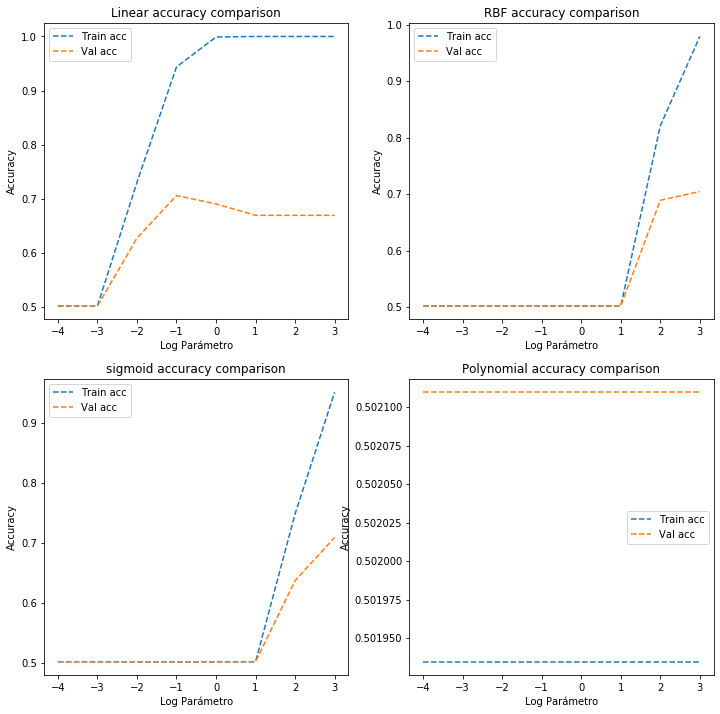

In [22]:



plt.figure(figsize = (12,12))
plt.subplot(2,2,1)
plt.plot(np.log10(Cs), svm_train_acc1, '--', label = 'Train acc', markersize = 10)
plt.plot(np.log10(Cs), svm_val_acc1, '--', label = 'Val acc')
plt.xlabel('Log Parámetro')
plt.ylabel('Accuracy')
plt.title('Linear accuracy comparison')
plt.legend()

plt.subplot(2,2,2)
plt.plot(np.log10(Cs), svm_train_acc2, '--', label = 'Train acc', markersize = 10)
plt.plot(np.log10(Cs), svm_val_acc2, '--', label = 'Val acc')
plt.xlabel('Log Parámetro')
plt.ylabel('Accuracy')
plt.title('RBF accuracy comparison')
plt.legend()


plt.subplot(2,2,3)
plt.plot(np.log10(Cs), svm_train_acc3, '--', label = 'Train acc', markersize = 10)
plt.plot(np.log10(Cs), svm_val_acc3, '--', label = 'Val acc')
plt.xlabel('Log Parámetro')
plt.ylabel('Accuracy')
plt.title('sigmoid accuracy comparison')
plt.legend()

plt.subplot(2,2,4)
plt.plot(np.log10(Cs), svm_train_acc4, '--', label = 'Train acc', markersize = 10)
plt.plot(np.log10(Cs), svm_val_acc4, '--', label = 'Val acc')
plt.xlabel('Log Parámetro')
plt.ylabel('Accuracy')
plt.title('Polynomial accuracy comparison')
plt.legend()


print('Accuracy máxima del caso lineal es ', max(svm_val_acc1),' y se alcanza en el parámetro C= ',
      Cs[np.argwhere(svm_val_acc1==max(svm_val_acc1))[0][0]], '\n' )
print('Accuracy máxima del caso rbf es ', max(svm_val_acc2),' y se alcanza en el parámetro C= ',
      Cs[np.argwhere(svm_val_acc2==max(svm_val_acc2))[0][0]], '\n' )
print('Accuracy máxima del caso sigmoid es ', max(svm_val_acc3),' y se alcanza en el parámetro C= ',
      Cs[np.argwhere(svm_val_acc3==max(svm_val_acc3))[0][0]], '\n')
print('Accuracy máxima del caso polinomial es ', max(svm_val_acc4),' y se alcanza en el parámetro C= ',
      Cs[np.argwhere(svm_val_acc4==max(svm_val_acc4))[0][0]])

Sorprendentemente, la mejor máquina de soporte vectorial fue aquella que utilizó el kernel lineal. Es decir, la frontera que separa nuestros datos es un frontera que se adapta mejor al caso lineal (es decir, de un hiperplano). La mejor accuracy se da para una tolerancia de margen C=0.1 (al igual que antes, esto es el inverso del parámetro de tolerancia, por lo tanto se da para C=10 en el problema de optimización). Debido a que la penalización es en norma l2, y en el caso lineal utilizamos el modelo Ridge, no es coincidencia que en ambos casos el regularizador haya sido el mismo (considerando que estamos en el mismo conjunto de parámetros). Esto se da solamente porque nuestros datos se adaptan mejor al problema lineal, como se vio en el modelo de regresión logística. Es por ello que el acc del kernel lineal es el mejor de todos.

In [23]:
#Red Neuronal

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
def do_ANN(x,y, xv,yv, param, act):
    print("Neuron hidden = ",param)
    model = Sequential()
    model.add(Dense(units=param, input_dim=x.shape[1], activation=act))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=SGD(lr=0.1), loss="binary_crossentropy", metrics=["accuracy"])
    model.summary()
    model.fit(x, y, epochs=25, batch_size=128, verbose=0)
    train_acc = model.evaluate(x,y, verbose=0) #in position 0 is the loss
    test_acc = model.evaluate(xv,yv, verbose=0)
    return model, train_acc, test_acc
N_h = [2**i for i in range(1,10)]

train_error = []
val_error = []
train_accu=[]
val_accu = []
for k in N_h:
  model, train_acc, val_acc = do_ANN(features_train, labels_train, features_val, labels_val,k, 'linear')
  train_error = train_error + [train_acc[0]]
  val_error = val_error + [val_acc[0]] 
  train_accu = train_accu + [train_acc[1]]
  val_accu = val_accu + [val_acc[1]]

Using TensorFlow backend.


Neuron hidden =  2





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2)                 17186     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3         
Total params: 17,189
Trainable params: 17,189
Non-trainable params: 0
_________________________________________________________________








Neuron hidden =  4
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 4)                 34372     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5         
Total params: 3

El menor error es de  0.5716498769117643  y se alcanza con una cantidad de neuronas igual a  512


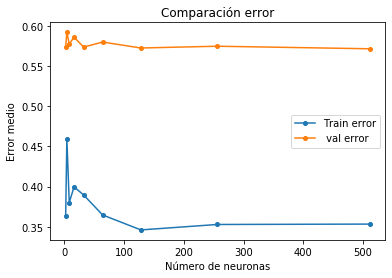

In [24]:
#Loss

plt.plot(N_h,train_error, '-o', label = 'Train error', markersize = 4)
plt.plot(N_h, val_error, '-o', label =' val error'  , markersize = 4)
plt.xlabel ('Número de neuronas')
plt.ylabel('Error medio')
plt.title('Comparación error')
plt.legend()

print('El menor error es de ', min(val_error), ' y se alcanza con una cantidad de neuronas igual a ',
      N_h[np.argwhere(val_error==min(val_error))[0][0]])

El mayor accuracy es de  0.7116736992669676  y se alcanza con una cantidad de neurones igual a  8


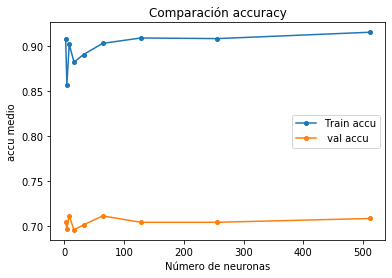

In [25]:
#Accuracy
plt.plot(N_h,train_accu, '-o', label = 'Train accu', markersize = 4)
plt.plot(N_h, val_accu, '-o', label =' val accu' , markersize = 4 )
plt.xlabel ('Número de neuronas')
plt.ylabel('accu medio')
plt.title('Comparación accuracy')
plt.legend()

print('El mayor accuracy es de ', max(val_accu), ' y se alcanza con una cantidad de neurones igual a ',
      N_h[np.argwhere(val_accu == max(val_accu))[0][0]])
opt_neur = N_h[np.argwhere(val_accu == max(val_accu))[0][0]]

In [26]:
train_error1 = []
val_error1 = []
train_accu1=[]
val_accu1 = []
for k in N_h:
  model, train_acc1, val_acc1 = do_ANN(features_train, labels_train, features_val, labels_val,k, 'sigmoid')
  train_error1 = train_error1 + [train_acc1[0]]
  val_error1 = val_error1 + [val_acc1[0]] 
  train_accu1 = train_accu1 + [train_acc1[1]]
  val_accu1 = val_accu1 + [val_acc1[1]]

Neuron hidden =  2
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 2)                 17186     
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 3         
Total params: 17,189
Trainable params: 17,189
Non-trainable params: 0
_________________________________________________________________
Neuron hidden =  4
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 4)                 34372     
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 5         
Total params: 34,377
Trainable params: 34,377
Non-trainable params: 0
__________________________________________________

El mayor accuracy es de  0.6554149086213816  y se alcanza con una cantidad de neurones igual a  32


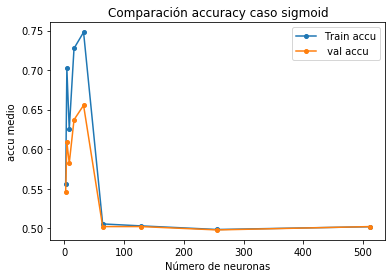

In [27]:
#Accuracy caso sigmoid

plt.plot(N_h,train_accu1, '-o', label = 'Train accu', markersize = 4)
plt.plot(N_h, val_accu1, '-o', label =' val accu', markersize = 4  )
plt.xlabel ('Número de neuronas')
plt.ylabel('accu medio')
plt.title('Comparación accuracy caso sigmoid')
plt.legend()

print('El mayor accuracy es de ', max(val_accu1), ' y se alcanza con una cantidad de neurones igual a ',
      N_h[np.argwhere(val_accu1 == max(val_accu1))[0][0]])

Debido a los resultados alcanzado en los problemas anteriores, decidimos utilizar la función de activación lineal ya que vimos que el problema se adaptaba de mejor manera a estos casos. Y no fue la excepción. Con acc de 0.72 para una cantidad de 256 neuornas, se consiguió igual el mismo resultados dado por el problema de regresión lineal. En cambio para el caso en que la función de activación fue la función sigmoidal vemos que el mayor accuracy es de 0.66 con una cantidad de 16 neuronas.

Esto confirma lo linealmente adaptable que es nuestro problema, teniendo en cuenta los modelos anteriores.

In [0]:
#K-NN

from sklearn.neighbors import KNeighborsClassifier
def do_KNN(x,y,xv,yv, param):
    model = KNeighborsClassifier()
    print("Param K= ",param)
    model.set_params(n_neighbors=param)
    model.fit(x,y)
    train_acc = model.score(x,y)
    test_acc = model.score(xv,yv)
    return model, train_acc, test_acc
steps = 25
Ks = np.arange(1, features_train.shape[0], steps)



In [29]:
nn_train_acc = []
nn_val_acc = []

for k in Ks:
  a,b,c = do_KNN(features_train, labels_train, features_val, labels_val, k)
  nn_train_acc = nn_train_acc + [b]
  nn_val_acc = nn_val_acc + [c]
  

Param K=  1
Param K=  26
Param K=  51
Param K=  76
Param K=  101
Param K=  126
Param K=  151
Param K=  176
Param K=  201
Param K=  226
Param K=  251
Param K=  276
Param K=  301
Param K=  326
Param K=  351
Param K=  376
Param K=  401
Param K=  426
Param K=  451
Param K=  476
Param K=  501
Param K=  526
Param K=  551
Param K=  576
Param K=  601
Param K=  626
Param K=  651
Param K=  676
Param K=  701
Param K=  726
Param K=  751
Param K=  776
Param K=  801
Param K=  826
Param K=  851
Param K=  876
Param K=  901
Param K=  926
Param K=  951
Param K=  976
Param K=  1001
Param K=  1026
Param K=  1051
Param K=  1076
Param K=  1101
Param K=  1126
Param K=  1151
Param K=  1176
Param K=  1201
Param K=  1226
Param K=  1251
Param K=  1276
Param K=  1301
Param K=  1326
Param K=  1351
Param K=  1376
Param K=  1401
Param K=  1426
Param K=  1451
Param K=  1476
Param K=  1501
Param K=  1526
Param K=  1551
Param K=  1576
Param K=  1601
Param K=  1626
Param K=  1651
Param K=  1676
Param K=  1701
Param K=  

El accuracy mayor de entrenamiento es :  1.0  en el parámetro K=  1
El accuracy mayor de validación es :  0.6118143459915611  en el parámetro K =  426


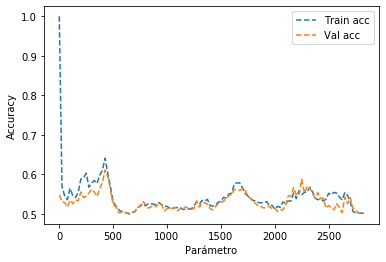

In [30]:
plt.plot(np.arange(1,2843, steps), nn_train_acc, '--', label = 'Train acc')
plt.plot(np.arange(1,2843, steps), nn_val_acc, '--', label = 'Val acc')
plt.xlabel('Parámetro')
plt.ylabel('Accuracy')
plt.legend()

print('El accuracy mayor de entrenamiento es : ', max(nn_train_acc), ' en el parámetro K= ', Ks[np.argwhere(nn_train_acc == max(nn_train_acc))[0][0]])

print('El accuracy mayor de validación es : ', max(nn_val_acc), ' en el parámetro K = ', Ks[np.argwhere(nn_val_acc == max(nn_val_acc))[0][0]])

No es coinciendia que el parámetro K=426 sea similar a la frecuencia de la palabra que más veces aparece en el dataset de entrenamiento ('film'). Ello nos muestra que justamente se aproxima mejor esta cantidad de vecinos a cada uno de los vectores creados debido hay más probabilidad de que la entrada de la palabra film esté en los vectores.

In [0]:
#Árbol de desición

from sklearn.tree import DecisionTreeClassifier as Tree
def do_Tree(x,y,xv,yv, param_d=None, param_m=2):
    model= Tree()
    print("Param Max-D= ",param_d, 'Min-samples-S= ', param_m)
    model.set_params(max_depth=param_d, min_samples_split=param_m) 
    model.fit(x,y)
    train_acc = model.score(x,y)
    test_acc = model.score(xv,yv)
    return model, train_acc, test_acc
steps = 250
Depths = np.arange(1, features_train.shape[1], steps ) #choose steps
SamplesS = np.arange(2, features_train.shape[0] , steps ) #choose steps

In [32]:
tree_train_acc = []
tree_val_acc = []

for k in Depths:
  for i in SamplesS:
    a,b,c = do_Tree(features_train, labels_train, features_val, labels_val, k,i)
    tree_train_acc = tree_train_acc + [b]
    tree_val_acc = tree_val_acc + [c]

Param Max-D=  1 Min-samples-S=  2
Param Max-D=  1 Min-samples-S=  252
Param Max-D=  1 Min-samples-S=  502
Param Max-D=  1 Min-samples-S=  752
Param Max-D=  1 Min-samples-S=  1002
Param Max-D=  1 Min-samples-S=  1252
Param Max-D=  1 Min-samples-S=  1502
Param Max-D=  1 Min-samples-S=  1752
Param Max-D=  1 Min-samples-S=  2002
Param Max-D=  1 Min-samples-S=  2252
Param Max-D=  1 Min-samples-S=  2502
Param Max-D=  1 Min-samples-S=  2752
Param Max-D=  251 Min-samples-S=  2
Param Max-D=  251 Min-samples-S=  252
Param Max-D=  251 Min-samples-S=  502
Param Max-D=  251 Min-samples-S=  752
Param Max-D=  251 Min-samples-S=  1002
Param Max-D=  251 Min-samples-S=  1252
Param Max-D=  251 Min-samples-S=  1502
Param Max-D=  251 Min-samples-S=  1752
Param Max-D=  251 Min-samples-S=  2002
Param Max-D=  251 Min-samples-S=  2252
Param Max-D=  251 Min-samples-S=  2502
Param Max-D=  251 Min-samples-S=  2752
Param Max-D=  501 Min-samples-S=  2
Param Max-D=  501 Min-samples-S=  252
Param Max-D=  501 Min-samp

In [33]:
si = np.argwhere(tree_val_acc == max(tree_val_acc))[0][0]
print('El máximo accuracy es = ' , max(tree_val_acc),' y se alcanza para una profundidad D= ', Depths[int(si/SamplesS.shape[0])], 
      ' y una cantidad mínima de muestra de ', SamplesS[si%SamplesS.shape[0]])


El máximo accuracy es =  0.6441631504922645  y se alcanza para una profundidad D=  4001  y una cantidad mínima de muestra de  752


In [34]:
#Evaluando sobre el mejor modelo obtenido. Fue la NN con 256 capas

model, train_acc, test_acc = do_ANN(features_train, labels_train, features_test, labels_test,opt_neur, 'linear')
#model.set_params(C=1000,kernel='rbf') #try rbf and linear at least
print('Train ', train_acc)
print('Test', test_acc)



Neuron hidden =  8
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 8)                 68744     
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 9         
Total params: 68,753
Trainable params: 68,753
Non-trainable params: 0
_________________________________________________________________
Train  [0.38406208095691424, 0.895884629122774]
Test [0.5796517506367582, 0.7062464828362408]


In [35]:
pip install vaderSentiment

     |████████████████████████████████| 133kB 8.8MB/s 


Como dice el enunciado de la pregunta, VADER es un modelo creado que analiza el 'sentimiento' de la oración. Él está creado de manera manual sobre un vocabulario ya establecido. 

Utilizando nuestro conjunto de oraciones de testeo, vemos que el accuracy es del 0.635, el cual queda muy por debajo de nuestra red neuronal (que fue el mejor modelo). Lo anterior sucede por dos razones. La primera, es que el modelo VADER está hecho con un vocabulario estándar, por lo tanto no se adhiere al contexto de nuestro problema (*film reviews*). Lo otro, es que nosotros sacamos más provecho aún de tener las oraciones en nuestro poder ya que pudimos identificar la forma lineal en la que se podían representar las reviews. El modelo VADER no lo hace, por la misma razón explicada anteriormente.

In [36]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
def vader_predict(sentences): 
    sid_obj = SentimentIntensityAnalyzer() 
    sent_v = []
    for text in sentences:
        sentiment_dict = sid_obj.polarity_scores(text) 
        if sentiment_dict["pos"] > sentiment_dict["neg"]: #based on scores
            sent_v.append(1)
        else:
            sent_v.append(0)
    return np.asarray(sent_v)
vader_pred_test = vader_predict(df_test_text) 
from sklearn.metrics import accuracy_score
accuracy_score(labels_test, vader_pred_test)

0.6359032076533483

In [37]:
vocab # Palabras set de entrenamiento

#model= SVM()
#model.set_params(C=1000,kernel='rbf', probability = True) #try rbf and linear at least
#model.fit(features_train,labels_train)
#print(model.score(features_train,labels_train))
#print(model.score(features_test, labels_test))
model1, train_acc1, test_acc1 = do_ANN(features_train, labels_train, features_test, labels_test,opt_neur, 'linear')
print(model1.evaluate(features_train, labels_train))
print(model1.evaluate(features_test, labels_test))

V = len(vocab)
word_score = np.zeros((V,2))
for k in np.arange(V):
  x_word = np.zeros((1,V))
  x_word[:,k] = 1
  a = model1.predict_proba(x_word)[0]
  b = 1-a
  #if model1.predict_classes(x_word)[0][0]==0:
  word_score[k] = np.array([b,a]).T #Probabilidades de que pertenezca a cada clases. Cada columna indica
                                            #una clase, partiendo desde el valor 0 en este caso que vendrían siendo las 
                                              #negativas


Neuron hidden =  8
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 8)                 68744     
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 9         
Total params: 68,753
Trainable params: 68,753
Non-trainable params: 0
_________________________________________________________________
2843/2843 [==============================] - 0s 70us/step
[0.3622788196607161, 0.9039746746394653]
3554/3554 [==============================] - 0s 69us/step
[0.5754514750162403, 0.7124366910523354]


En lo anterior lo único que hicimos fue testear, palabra por palabra de nuestro vocabulario de entrenamiento, cómo ellas son identificadas por nuestro modelo: positivas o negativas. Ello para ver cómo se le da peso individualmente a nuestras palabras. En el cuadro de abajo se muestran las 5 palabras más negativas y las 5 palabras más positivas.

Por un lado, las palabras negativas tienen coherencia con lo que sucede en la realidad. Palabras como *bad* (malo), *boring, dull* (aburrido), *silly* (ridícula), son palabras de connotación negativa y que rara vez se utilizan en otro contexto. De hecho, en el contexto de una crítica, la palabra *problema* es utilizada generalmente como negativa y es por eso que nuestra red logra identificarla como negativa. Cabe destacar la gran probabilidad con la que estas palabras destacan en sus categorías.

Por otro lado, las palabras positivas si se adaptan al contexto de las críticas pero no tanto en nuestro vocabulario en general. Por ejemplo, la palabra *performance* (actuación) en el contexto de críticas de cine (sobre todo críticas escritas en inglés) es utilizada como positiva. Sin embargo, nuestra red la muestra como la palabra que con mayor seguridad es positiva alcazando sólo un 67% de seguridad.

In [38]:
dic = {}
dic['Vocabulario'] = vocab
dic['Prob Negativo'] = word_score[:,0]
dic['Prob Positivo'] = word_score[:,1]
resume = pd.DataFrame(dic)
neg = np.argwhere(max(resume['Prob Negativo'].values)==resume['Prob Negativo'])[0][0]
pos = np.argwhere(min(resume['Prob Negativo'].values)==resume['Prob Negativo'])[0][0]

print('Las palabras más negativas fueron \n')
print(resume.sort_values(by = 'Prob Negativo', axis = 0, ascending = False).head(), '\n')

print('Mientras que las más positivas fueron \n')
print(resume.sort_values(by = 'Prob Positivo', axis = 0, ascending = False).head())

Las palabras más negativas fueron 

     Vocabulario  Prob Negativo  Prob Positivo
613          bad       0.833422       0.166578
889       boring       0.776297       0.223703
2303        dull       0.771122       0.228878
6093      really       0.748522       0.251478
6842       silly       0.723907       0.276093 

Mientras que las más positivas fueron 

      Vocabulario  Prob Negativo  Prob Positivo
5524  performance       0.287132       0.712868
3139          fun       0.287196       0.712804
3523        heart       0.307740       0.692260
4976       moving       0.310383       0.689617
6052         rare       0.322636       0.677364


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


In [0]:
#n)


En lo que sigue utilizamos un vectorizador distinto al del item c). En este caso se le da no sólo importancia a la frecuencia con la que aparece la palabra en una frase, si no que se suma (el logaritmo) se fue frecuencia en todo el documento (texts_train en este caso). Ello da un significado más preciso del peso que tienen alguna de las palabras en nuestro vocabulario ya que una palabra puede aparecer 5 veces en una frase, pero puede ser que sólo aparezca en esa frase de un universo grande de frases (en este caso 2500 app). Por lo tanto, nuestro nuevo pre procesamiento toma en cuenta el peso de la palabra en todo nuestro vocabulario de frases.

In [0]:
#O)
#Term frequency times inverse document frequency
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_model = TfidfVectorizer(binary=False, ngram_range=(1,1), max_df=1.0, min_df=2, max_features=None, 
                              norm='l2', use_idf=True, sublinear_tf=False, smooth_idf = True)
tfidf_model.fit(texts_train)

menos_freq_train = tfidf_model.transform(texts_train)
menos_freq_val = tfidf_model.transform(texts_val)
menos_freq_test = tfidf_model.transform(texts_test)

En base al nuevo conjunto de entrenamiento ya definido, se decidió testear distintas formas de pre procesar nuestros datos. Alguna de ellas es eliminar aquellas palabras con pocas frecuencia o cambiar la forma en que se leen las frases (ngam). Testearemos estos nuevos datos en los casos de nuestra red neuronal (que fue el mejor modelo) y el modelo de regresión logística que nos mostró lo bien adaptado que está al caso lineal nuestro problema (De hecho, consigue un acc similar al de nuestra red).

In [40]:
train1_error = []
val1_error = []
train1_accu=[]
val1_accu = []
tokenis1 = TfidfVectorizer(binary=False, ngram_range=(1,1), max_df=1.0, min_df=2, max_features=None, 
                              norm='l2', use_idf=True, sublinear_tf=False, smooth_idf = True)
tokenis2 = TfidfVectorizer(binary=False, ngram_range=(1,1), max_df=1.0, min_df=3, max_features=None, 
                              norm='l2', use_idf=True, sublinear_tf=False, smooth_idf = True)
tokenis3 = TfidfVectorizer(binary=False, ngram_range=(1,2), max_df=1.0, min_df=1, max_features=None, 
                              norm='l2', use_idf=True, sublinear_tf=False, smooth_idf = True)
tokenis4 = TfidfVectorizer(binary=False, ngram_range=(2,2), max_df=1.0, min_df=1, max_features=None, 
                              norm='l2', use_idf=True, sublinear_tf=False, smooth_idf = True)
modelos = [tokenis1,tokenis2,tokenis3,tokenis4]

for claro in modelos:
  claro.fit(texts_train)

  menos_freq_train = claro.transform(texts_train)
  menos_freq_val = claro.transform(texts_val)
  menos_freq_test = claro.transform(texts_test)
  for k in N_h:
    model1_menos_freq, train1_acc, val1_acc = do_ANN(menos_freq_train,labels_train, menos_freq_test,labels_test,
                                                              k,'linear')
    train1_error = train1_error + [train1_acc[0]]
    val1_error = val1_error + [val1_acc[0]] 
    train1_accu = train1_accu + [train1_acc[1]]
    val1_accu = val1_accu + [val1_acc[1]]

Neuron hidden =  2
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 2)                 7802      
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 3         
Total params: 7,805
Trainable params: 7,805
Non-trainable params: 0
_________________________________________________________________
Neuron hidden =  4
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 4)                 15604     
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 5         
Total params: 15,609
Trainable params: 15,609
Non-trainable params: 0
____________________________________________________

En los gráficos de abajo, se logra ver que el mejor accuracy es de 0.69, que es menor al original. Por lo tanto este cambio de preprocesamiento no logra mejorar nuestra red.

El mayor accuracy es del caso  Frecuencia al menos de 2  es :  0.6789532920652785  y se alcanza con una cantidad de neurones igual a  512
El mayor accuracy es del caso  Frecuencia al menos 3  es :  0.6803601575689364  y se alcanza con una cantidad de neurones igual a  16
El mayor accuracy es del caso  (1,2) ngam  es :  0.6935846933033202  y se alcanza con una cantidad de neurones igual a  16
El mayor accuracy es del caso  (2,2) ngam  es :  0.5551491277433878  y se alcanza con una cantidad de neurones igual a  512


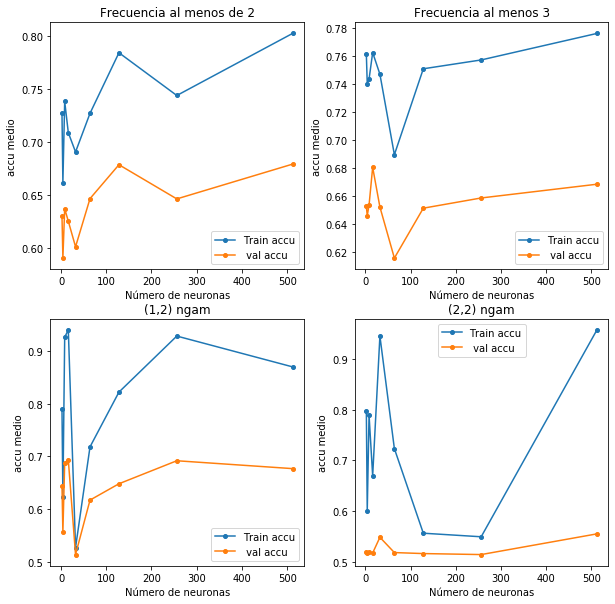

In [41]:
larguito = len(N_h)
casos = ['Frecuencia al menos de 2', 'Frecuencia al menos 3', '(1,2) ngam', '(2,2) ngam']
plt.figure(figsize= (10,10))
for k in np.arange(4):
  plt.subplot(2,2,k+1)
  plt.plot(N_h,train1_accu[k*larguito:(k+1)*larguito], '-o', label = 'Train accu', markersize = 4)
  plt.plot(N_h, val1_accu[k*larguito:(k+1)*larguito], '-o', label =' val accu' , markersize = 4 )
  plt.xlabel ('Número de neuronas')
  plt.ylabel('accu medio')
  plt.title(casos[k])
  plt.legend()

  print('El mayor accuracy es del caso ', casos[k] ,' es : ', max(val1_accu[k*larguito:(k+1)*larguito]), ' y se alcanza con una cantidad de neurones igual a ',
      N_h[np.argwhere(val1_accu[k*larguito:(k+1)*larguito] == max(val1_accu[k*larguito:(k+1)*larguito]))[0][0]])

Ahora, haciendo el testeo para el caso de la regresión logística, considerando los mismos pre porcesamientos para la NN, tenemos que el modelo mejor considerablemente al original. De hecho, la mejor se da en el caso que considera ngam = (1,2). Lo anterior es debido a que en este caso estamos considerando monograma y bigramas al mismo tiempo. Por lo tanto tenemos muchísimos más datos y, claramente, el modelo sigue siendo lineal ya que logra mejorarlalo en casi 2 puntos porcentuales.

Param C=  0.0001
Param C=  0.001
Param C=  0.01
Param C=  0.1
Param C=  1.0
Param C=  10.0
Param C=  100.0
Param C=  1000.0
Param C=  0.0001
Param C=  0.001


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Param C=  0.01
Param C=  0.1
Param C=  1.0
Param C=  10.0
Param C=  100.0
Param C=  1000.0
Param C=  0.0001
Param C=  0.001
Param C=  0.01
Param C=  0.1
Param C=  1.0
Param C=  10.0
Param C=  100.0
Param C=  1000.0


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Param C=  0.0001
Param C=  0.001
Param C=  0.01
Param C=  0.1
Param C=  1.0
Param C=  10.0
Param C=  100.0
Param C=  1000.0
Accuracy Máxima para el caso Frecuencia al menos de 2  es  0.7298818232976927  y se alcanza en el parámetro C=  1.0
Accuracy Máxima para el caso Frecuencia al menos 3  es  0.7189082723691615  y se alcanza en el parámetro C=  1.0
Accuracy Máxima para el caso (1,2) ngam  es  0.7355092853123242  y se alcanza en el parámetro C=  100.0
Accuracy Máxima para el caso (2,2) ngam  es  0.5832864378165448  y se alcanza en el parámetro C=  1.0


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


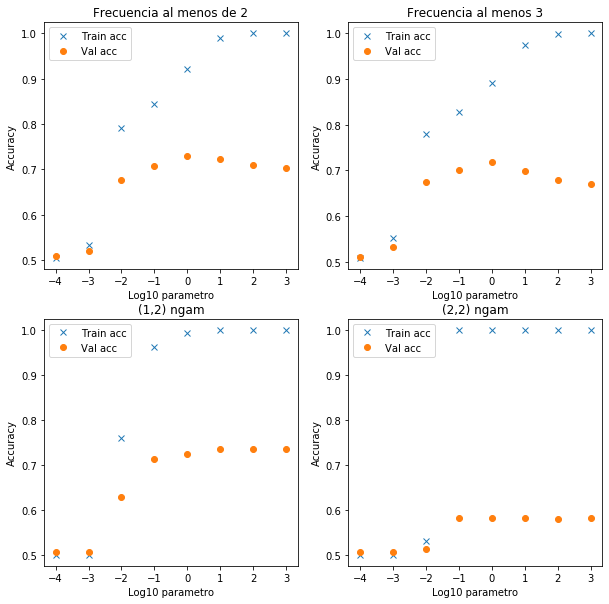

In [42]:
train1_log_acc = []
val1_log_acc = []
log_models = []
for claro in modelos:
  claro.fit(texts_train)
  menos_freq_train = claro.transform(texts_train)
  menos_freq_val = claro.transform(texts_val)
  menos_freq_test = claro.transform(texts_test)
  for k in Cs:
    a,b,c = do_LOGIT(menos_freq_train, labels_train, menos_freq_test, labels_test, k)
    train1_log_acc = train1_log_acc + [b]
    val1_log_acc = val1_log_acc + [c]
    log_models = log_models + [a]

largo1 = len(Cs)
plt.figure(figsize = (10,10))
for k in np.arange(4):
  plt.subplot(2,2,k+1)
  plt.plot(np.log10(Cs), train1_log_acc[k*largo1:(k+1)*largo1], 'x', label = 'Train acc')
  plt.plot(np.log10(Cs), val1_log_acc[k*largo1:(k+1)*largo1], 'o', label= 'Val acc')
  plt.xlabel('Log10 parametro')
  plt.ylabel('Accuracy')
  plt.title(casos[k])
  plt.legend()

  print('Accuracy Máxima para el caso' , casos[k], ' es ', max(val1_log_acc[k*largo1: (k+1)*largo1]),
        ' y se alcanza en el parámetro C= ',
        Cs[np.argwhere(val1_log_acc[k*largo1: (k+1)*largo1]==max(val1_log_acc[k*largo1: (k+1)*largo1]))[0][0]] )

Para el caso de nuestra red, estudiamos la precisón y la exhaustividad de nuestro modelo NN. En ello vemos que existe una ligera tendencia a identificar mejor a los positivos pero logra encontrar mayores casos negativos de todo el universo(recall). El f1-score es simplemente la media armónica de la precisión y el recall. Lo anteiror puede darse por lo mostrado al principio de la tarea y es que vimos que existían ligeramente más reseñas positivas que negativas dentro de nuestro data set. Sin embargo, con esta información y debido a la poca diferencia entre ambas es dificil identificar dónde se encuentra el punto a mejorar. 

In [43]:
#P)

from sklearn.metrics import classification_report
def score_the_model(model, x, y):
    print("Detailed Analysis Testing Results ...")
    print(classification_report(y, model1.predict_classes(x), target_names=['-','+']))
print(score_the_model(model1, features_test, labels_test ))
print(score_the_model(log_models[2], features_test,labels_test))

Detailed Analysis Testing Results ...
              precision    recall  f1-score   support

           -       0.72      0.72      0.72      1803
           +       0.71      0.71      0.71      1751

    accuracy                           0.71      3554
   macro avg       0.71      0.71      0.71      3554
weighted avg       0.71      0.71      0.71      3554

None
Detailed Analysis Testing Results ...
              precision    recall  f1-score   support

           -       0.72      0.72      0.72      1803
           +       0.71      0.71      0.71      1751

    accuracy                           0.71      3554
   macro avg       0.71      0.71      0.71      3554
weighted avg       0.71      0.71      0.71      3554

None


In [44]:
#Q)
model2 = log_models[2]
classes_weights = {0: 5, 1: 1} #or choose..
model2.set_params(class_weight=classes_weights)
model2.fit(features_train, labels_train)
score_the_model(model2, features_test, labels_test)

Detailed Analysis Testing Results ...


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           -       0.72      0.72      0.72      1803
           +       0.71      0.71      0.71      1751

    accuracy                           0.71      3554
   macro avg       0.71      0.71      0.71      3554
weighted avg       0.71      0.71      0.71      3554



Ya finalizando nuestro informe, a continuación mostraremos las oraciones de nuestro data set de testeo, con su respectiva categoría y la predicha por nuestro modelo.

Podemos observar algunos casos en los que el modelo falló en predecir nuestra salida original, pero viendo la probabilidad, siempre es cercana a 0.5 ( oscila entre 0.45 y 0.55). Por lo tanto, sin lugar a duda, que una representación continua da mucha más información de una discreta (categoríca) ya que podemos saber con qué seguridad nuestro modelo está etiqutando nuestro input. 
Por ejemplo, si nos dice que es una crítica *positiva* pero con un 55% de seguridad, no podemos confiar compeltamente en ello. 

In [45]:
#R)

test_pred = model1.predict_proba(features_test) #or ".predict"
spl = np.random.randint( 0, len(test_pred), size=15)
for text, pred_s, true_s in zip(df_test_text[spl], test_pred[spl], labels_test[spl]):
    #if pred_s >=0.5:
      print("True sent: ", true_s, "-- Pred sent: ",pred_s)
      print("Raw text: ", text)
   # else:
   #   print("True sent: ", true_s, "-- Pred sent: ",1- pred_s)
    #  print("Raw text: ", text)

True sent:  0.0 -- Pred sent:  [0.31079066]
Raw text:  there's undeniable enjoyment to be had from films crammed with movie references , but the fun wears thin -- then out -- when there's nothing else happening .

True sent:  1.0 -- Pred sent:  [0.30926856]
Raw text:  " the emperor's new clothes " begins with a simple plan . . . . well , at least that's the plan .

True sent:  0.0 -- Pred sent:  [0.27023235]
Raw text:  the movie straddles the fence between escapism and social commentary , and on both sides it falls short .

True sent:  0.0 -- Pred sent:  [0.26405653]
Raw text:  it's best to avoid imprisonment with the dull , nerdy folks that inhabit cherish .

True sent:  0.0 -- Pred sent:  [0.20200804]
Raw text:  this is a movie that starts out like heathers , then becomes bring it on , then becomes unwatchable .

True sent:  0.0 -- Pred sent:  [0.5734802]
Raw text:  director yu seems far more interested in gross-out humor than in showing us well-thought stunts or a car chase that we 

(S) 
En base a todo lo realizado anteriormente, creemos que la parte más importante fue identificar nuestro espacio de hipótesis. Testeando distintos modelos logramos identificar que la frontera de nuestro problema es más lineal de lo que pensabamos (esto se ve en el buen desempeño de la regresión logística, la linealidad de la NN y el kernel lineal de la SVM. Estos modelos tuvieron las mejores acc y son todos de frontera lineal). 
Sin embargo, estmaos tentandos a pensar que esto es debido al pre procesamiento de nuestros datos. Al final de la tarea se realizaron varios cambios a los datos de entrenamiento y testeo. Como eliminando las palabras menos frecuentes (lo que disminuye nuestro data set) pero ello supondría aún un modelo lienal debido a que simplemente sería un subconjunto. El gran cambio es considerar poligramas, ya que puede transformar drásticamente nuestro problema. Pero en base a los gráficos mostrados anteriormente a los nuevos data set, vemos que el modelo lineal de la NN y el modelo de regresión logística tuvieron un comoportamiento similar o mejor (en el caso de regresión). Por lo tanto, para este problema (con el data set en mano) consideramos que la mejor forma fue identificar los distintos posibles modelos existentes para poder mejorar el rendimiento (claramente con lo anterior nos referimos a todo el modelo, incluyendo los parámetros).